In [85]:
import glob
import random
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import multiprocessing
import torch
import torch.nn as nn
import torchvision.models
from keras.preprocessing.sequence import pad_sequences
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, models, transforms
from torchvision.transforms import v2

# Traditional Features Construction

In [2]:
def get_image():
    path = "../DataSet/Training/Normal"
    folders = os.listdir(path)
    no_of_images = []
    
    for folder in folders:
        files = [f for f in os.listdir(f"{path}/{folder}") if os.path.isfile(os.path.join(f"../Resized/{folder}", f))]
        no_of_images.append(len(files))
        
    training_collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"{path}/{folder}")
        training_collection[folder] = all_files
        
        
    path = "../DataSet/Testing/Normal"
    folders = os.listdir(path)
    no_of_images = []
    
    for folder in folders:
        files = [f for f in os.listdir(f"{path}/{folder}") if os.path.isfile(os.path.join(f"../Resized/{folder}", f))]
        no_of_images.append(len(files))
        
    testing_collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"{path}/{folder}")
        testing_collection[folder] = all_files
        
    return training_collection, testing_collection

In [3]:
training_image_collection, testing_image_collection = get_image()

In [4]:
def feature_extraction(path, new_path, folder, image):
    path = path + "/" + folder + "/" + image
    loaded_image = cv.imread(path)

    gray = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img = cv.drawKeypoints(gray, kp, loaded_image)
    
    new_path = new_path + "/" + folder
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    new_path = new_path + "/" + image
    cv.imwrite(new_path, img)

In [5]:
def get_features(loc="Training"):
    folders = []
    image_collections = training_image_collection
    path = f"../DataSet/{loc}/Normal"
    new_path = f"../DataSet/{loc}/Feature Constructed"

    if not os.path.exists(path):
        os.mkdir(path)
    if loc == "Testing":
        image_collections = testing_image_collection
        
    for folder, images in image_collections.items():
        for image in images:
            folders.append(folder)
            feature_extraction(path, new_path, folder, image)
    
    return folders

In [6]:
training_folders = get_features()

In [7]:
def get_dataset(path):
    images = glob.glob(f"../DataSet/{path}/Feature Constructed/*/*")
        
    return images

In [8]:
training_img = get_dataset("Training")

In [9]:
def dataset_target(images, folder):
    targets = {f: 0 for f in folder}  
    for i, a in enumerate(images):
        b = a.split("\\")
        targets[b[1]] += 1
    
    target_images = []
    for i, (k, v) in enumerate(targets.items()):
        target_images = np.concatenate((target_images, np.full(v, i)), axis = 0) 
        
    return target_images

In [10]:
training_images_target = dataset_target(training_img, training_folders)

In [11]:
def plot_img_keypoints(img):    
    img = plt.imread(img)
    plt.imshow(img)

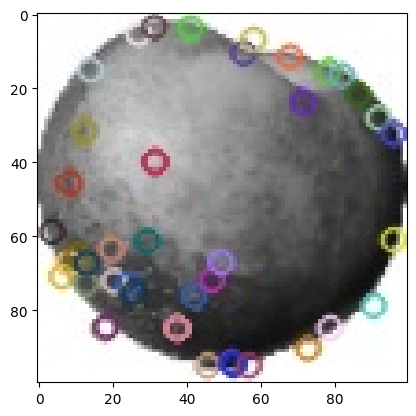

In [12]:
random_image = random.choices(training_img)
plot_img_keypoints(random_image[0])

In [13]:
def create_new_keypoints(image_set=training_img):
    keypoints = []
    
    for image in image_set:
        loaded_image = cv.imread(image)
        gray = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
        sift = cv.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        
        keypoints.extend(kp)
    
    keypoints = np.array([kp.pt for kp in keypoints])
    
    return keypoints

In [14]:
training_img_keypoints = create_new_keypoints()

In [15]:
def k_means_clustering(X):
    kmeans = KMeans(n_clusters=100, random_state=0, init="random", n_init="auto").fit(X)    
    return kmeans

In [16]:
def plot_clusters(X):
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans")
    plt.show()

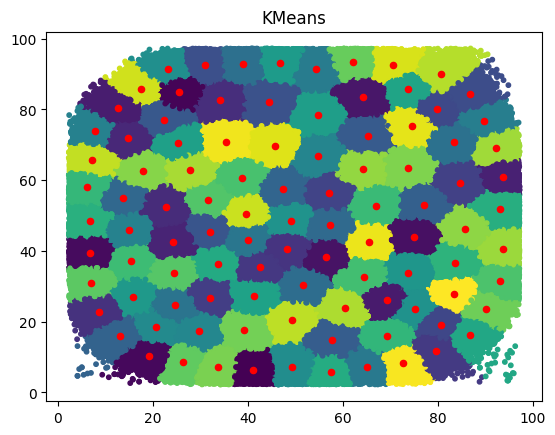

In [17]:
kmeans = k_means_clustering(training_img_keypoints)
plot_clusters(training_img_keypoints)

In [18]:
def learned_training_vector_images():
    image_vectors = []
    
    for image in training_img:
        loaded_image = cv.imread(image)
        gray = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
        sift = cv.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        keypoint = np.array([kp_obj.pt for kp_obj in kp])
        cluster_labels = kmeans.predict(keypoint)
        cluster_counts = np.bincount(cluster_labels, minlength=kmeans.n_clusters)
        image_vectors.append(cluster_counts)
    
    return np.array(image_vectors)    

In [19]:
learned_training_image = learned_training_vector_images()

In [26]:
learned_training_image

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [2, 1, 0, ..., 0, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
def dimension_reduction(features):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(features)
    
    for i in range(10):
        c = np.flatnonzero(training_images_target == i)
        plt.scatter(transformed_data[c, 0], transformed_data[c, 1])
        plt.title("PCA-reduced feature visualization")
    plt.show()

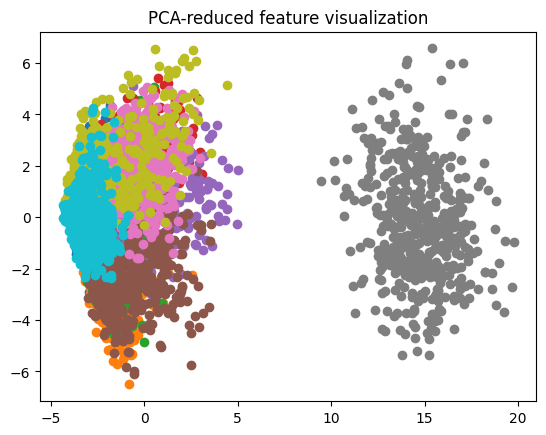

In [21]:
dimension_reduction(learned_training_image)

# Processing Test Images

In [22]:
testing_folders = get_features("Testing")

In [23]:
testing_img = get_dataset("Testing")

In [24]:
testing_images_target = dataset_target(testing_img, testing_folders)

In [25]:
testing_img_keypoints = create_new_keypoints(testing_img)

In [27]:
def learned_testing_vector_images():
    image_vectors = []
    
    for image in testing_img:
        loaded_image = cv.imread(image)
        gray = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
        sift = cv.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        keypoint = np.array([kp_obj.pt for kp_obj in kp])
        cluster_labels = kmeans.predict(keypoint)
        cluster_counts = np.bincount(cluster_labels, minlength=kmeans.n_clusters)
        image_vectors.append(cluster_counts)
    
    return np.array(image_vectors)   

In [28]:
learned_testing_image = learned_testing_vector_images()

In [29]:
learned_testing_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=int64)

# Traditional Machine Learning model - Support Vector Machine (SVM)

In [30]:
def train_svm(kernel_type="linear"):
    X_train = learned_training_image
    X_test = learned_testing_image
    y_train = training_images_target
    y_test = testing_images_target
    
    train_scores = []
    test_scores = []
    parameters = [0.01, 0.1, 1.0, 10, 100]
    for c in parameters:
        svc = SVC(kernel=kernel_type, C=c, random_state=42)
        svc.fit(X_train, y_train)
        train_scores.append(1 - svc.score(X_train, y_train))
        test_scores.append(1 - svc.score(X_test, y_test))
    
    return [train_scores, test_scores]

In [31]:
linear_train_score, linear_test_score = train_svm()

In [38]:
def plot_svm_performance(kernel_type, train_score, test_score):
    parameters = [0.01, 0.1, 1.0, 10, 100]
    plt.plot(parameters, train_score, marker="o", label="Training Error")
    plt.plot(parameters, test_score, marker="o", label="Testing Error")
    plt.xscale("log")
    plt.xlabel("log(C)")
    plt.ylabel("Error")
    plt.title(f"{kernel_type} SVM Performance")
    plt.legend()
    plt.grid()
    plt.show()

In [33]:
def train_svm_for_different_kernels():
    scores = []
    kernel_type = ["rbf", "poly", "sigmoid"]
    for kernel in kernel_type:
        scores.extend([train_svm(kernel)])
    
    scores.insert(0, [linear_train_score, linear_test_score])
    
    return scores

In [34]:
total_scores = train_svm_for_different_kernels()

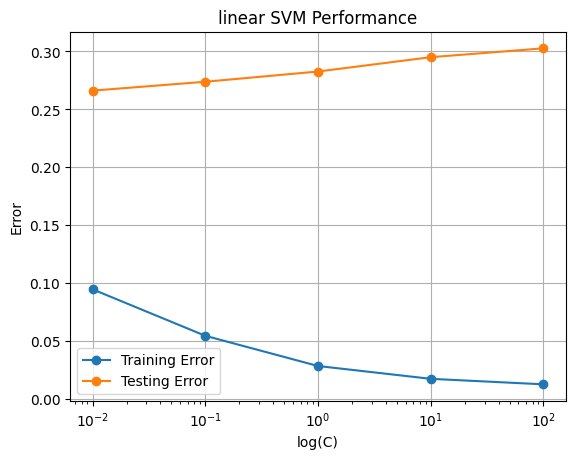

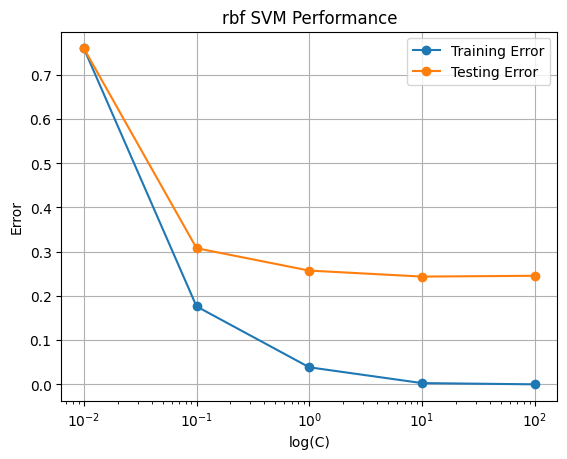

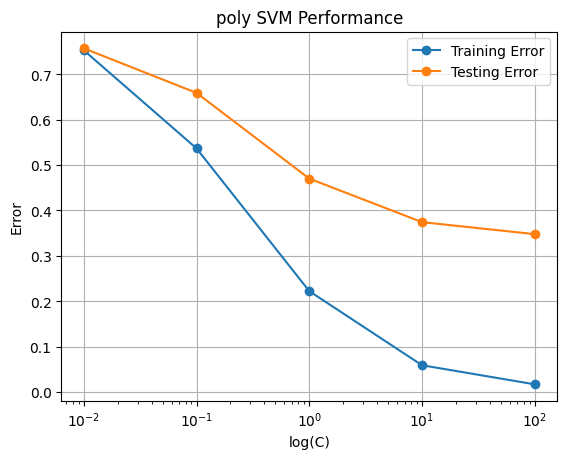

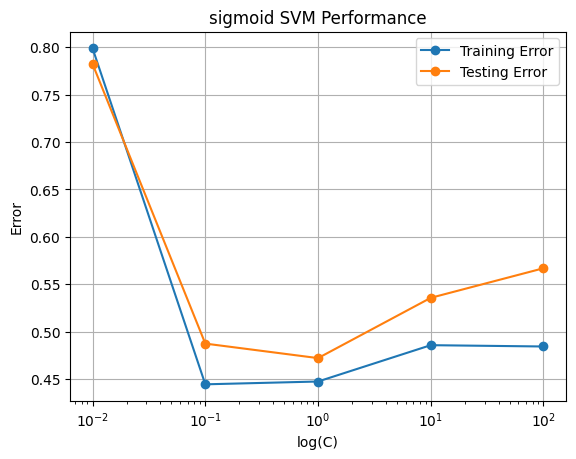

In [39]:
kernel_type = ["linear", "rbf", "poly", "sigmoid"]
for kernel, scores in zip(kernel_type, total_scores):
    plot_svm_performance(kernel, scores[0], scores[1])

In [40]:
def best_performing_svm():
    best_values = {}  
    best_train_score = []
    best_test_score = []
    parameters = [0.01, 0.1, 1.0, 10, 100]
    for kernel, scores in zip(kernel_type, total_scores):
        best_train_score.append(min(scores[0]))
        best_test_score.append(min(scores[1]))
        best_values[kernel] = [min(scores[1]), parameters[scores[1].index(min(scores[1]))]]

    plt.scatter(kernel_type, best_train_score, label="Training Error")
    plt.scatter(kernel_type, best_test_score, label="Testing Error")
    plt.xlabel("Kernels")
    plt.ylabel("Error")
    plt.title("Best SVM Performance Comparison")
    plt.legend()
    plt.show()

    return best_values

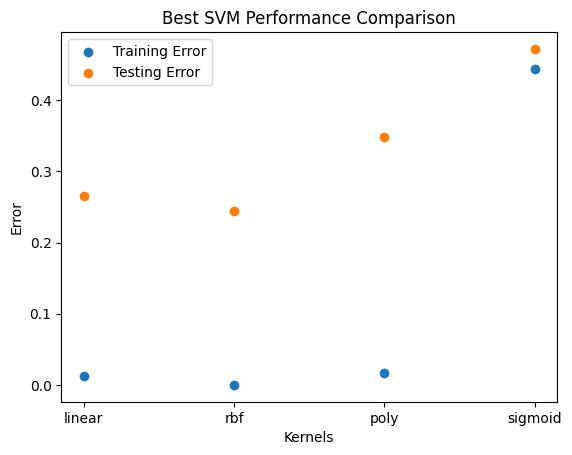

In [41]:
best_values = best_performing_svm()

# Deep Learning - Training a Simple Convolution Neural Network Mode

In [42]:
def get_original_dataset(path):
    images = glob.glob(f"../DataSet/{path}/Normal/*/*")
    return images

In [43]:
def get_pixels(images):
    combine = []
    for img in images:
        loaded_image = cv.imread(img)
        combine.append(loaded_image)
    
    return np.array(combine)

In [44]:
original_training_image = get_original_dataset("Training")
original_testing_image = get_original_dataset("Testing")

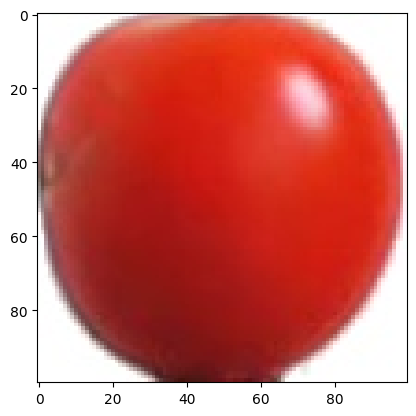

In [45]:
random_training_image = random.choices(original_training_image)
plot_img_keypoints(random_training_image[0])

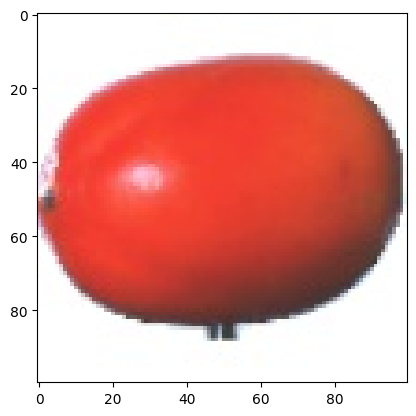

In [46]:
random_testing_image = random.choices(original_testing_image)
plot_img_keypoints(random_testing_image[0])

In [47]:
original_training_img = get_pixels(original_training_image)
original_testing_img = get_pixels(original_testing_image)

In [48]:
def images_classifier():
    num_classes = 10
    input_shape = (100, 100, 3)
    
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape), 
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),  
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),  
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(), 
            layers.Dense(16, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(num_classes, activation="softmax")
        ]
    )
    
    model.summary()
    
    return model

In [49]:
model = images_classifier()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       294,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,178 (1.13 MB)

 Trainable params: 296,178 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
def train_model():
    batch_size = 128
    num_epochs = 40
    
    X_train = np.reshape(original_training_img, (original_training_img.shape[0], 100, 100, 3))
    X_test = np.reshape(original_testing_img, (original_testing_img.shape[0], 100, 100, 3))
    
    X_train = X_train.astype("float32") / 255
    X_test = X_test.astype("float32") / 255
    
    y_train = to_categorical(training_images_target, num_classes=10)
    y_test = to_categorical(testing_images_target, num_classes=10)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))
    
    return model, model_history, X_test, y_test

In [51]:
model, model_history, X_test, y_test = train_model()

Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.2515 - loss: 2.0422 - val_accuracy: 0.8099 - val_loss: 0.6652
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9149 - loss: 0.3509 - val_accuracy: 0.9370 - val_loss: 0.2268
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9942 - loss: 0.0395 - val_accuracy: 0.9529 - val_loss: 0.1557
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9971 - loss: 0.0177 - val_accuracy: 0.9582 - val_loss: 0.1632
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9998 - loss: 0.0077 - val_accuracy: 0.9682 - val_loss: 0.0908
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9999 - loss: 0.0058 - val_accuracy: 0.9582 - val_loss: 0.1485
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9712 - val_loss: 0.0859
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9635 - v

In [52]:
def model_evaluation():
    score = model.evaluate(X_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

In [53]:
model_evaluation()

Test loss: 0.12929672002792358
Test accuracy: 0.969393789768219


In [54]:
def plot_learning_curve():    
    plt.plot(model_history.history["accuracy"], label="Training Accuracy")
    plt.plot(model_history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Number of epochs")
    plt.ylabel("Training and validation accuracy")
    plt.title("Learning curve")
    plt.grid(True)
    plt.legend()
    plt.show()

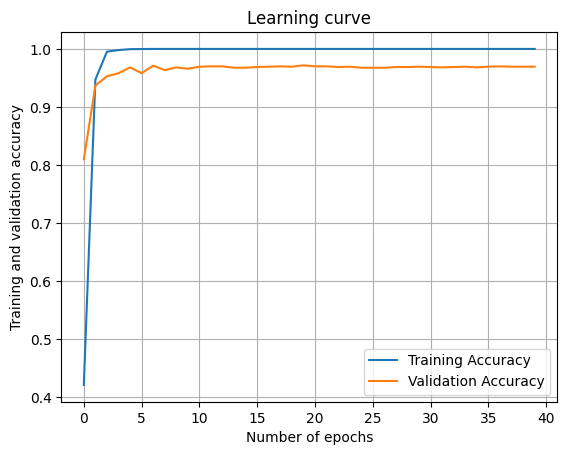

In [55]:
plot_learning_curve()

# Transfer Learning via Feature Extraction

In [56]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [57]:
def preprocessing_read(images):
    data_transforms = v2.Compose([
        v2.Resize((224,224)),   
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ])

    image_classes = []
    for image in images:
        transformed_images = data_transforms(image)
        image_classes.append(transformed_images)
    
    return image_classes

In [58]:
def data_loader():    
    training_image_classes = preprocessing_read(original_training_img)
    training_target_classes = preprocessing_read(training_images_target)
    validation_image_classes = preprocessing_read(original_testing_img)
    validation_target_classes = preprocessing_read(testing_images_target)
    
    training_data = CustomDataset(training_image_classes, training_target_classes, transform=None)
    validation_data = CustomDataset(validation_image_classes, validation_target_classes, transform=None)
    
    training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)
    
    return training_loader, validation_loader

In [59]:
training_loader, validation_loader = data_loader()

C:\Users\noill\OneDrive\Desktop\module\4. Senior Year\MACHINE LEARNING I\virtual\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [60]:
def freeze_all_model_building():
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False    

    features = model.fc.in_features
    num_classes = 10

    model.fc = nn.Linear(features, num_classes)
    
    return model

In [61]:
freezed_model = freeze_all_model_building()

C:\Users\noill\OneDrive\Desktop\module\4. Senior Year\MACHINE LEARNING I\virtual\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\noill\OneDrive\Desktop\module\4. Senior Year\MACHINE LEARNING I\virtual\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
freezed_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
device

device(type='cuda')

In [64]:
def freeze_all_model_training():    
    num_epochs = 10
    accuracy = {"training_accuracy": [], "validation_accuracy": []}

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(freezed_model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    for i in range(num_epochs):
        train_acc = 0
        val_acc = 0
        
        freezed_model.train()
        
        for image, label in training_loader:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = freezed_model(image)
            loss = criterion(outputs, label.long())
            loss.backward()
            optimizer.step()
            _, pred = torch.max(outputs, 1)
            train_acc += (pred == label).sum().item()

        train_acc /= len(training_loader.dataset)
        accuracy["training_accuracy"].append(train_acc)


        scheduler.step()
        freezed_model.eval()
        with torch.no_grad():
            for image, label in validation_loader:
                image, label = image.to(device), label.to(device)
                outputs = freezed_model(image)
                _, pred = torch.max(outputs, 1)
                val_acc += (pred == label).sum().item()
        
        val_acc /= len(validation_loader.dataset)       
        accuracy["validation_accuracy"].append(val_acc)
        

    return accuracy

In [65]:
freeze_all_accuracy = freeze_all_model_training()

In [66]:
def plot_resnet_learning_curve(accuracy):    
    plt.plot(accuracy["training_accuracy"], label="Training Accuracy")
    plt.plot(accuracy["validation_accuracy"], label="Validation Accuracy")
    plt.xlabel("Number of epochs")
    plt.ylabel("Training and validation accuracy")
    plt.title("Learning curve")
    plt.grid(True)
    plt.legend()
    plt.show()

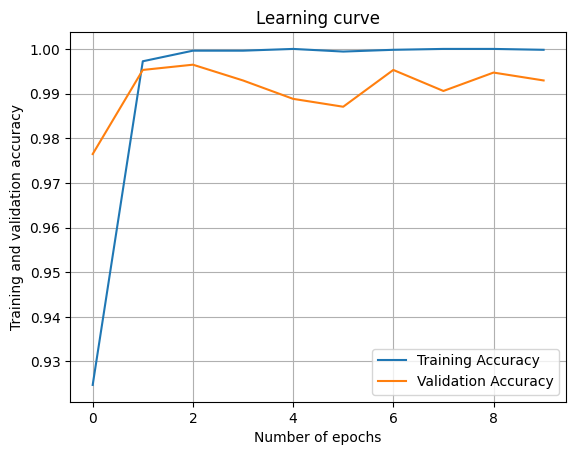

In [67]:
plot_resnet_learning_curve(freeze_all_accuracy)

In [69]:
def forward_hook_model_building():
    model = models.resnet18(pretrained=True)
    model = nn.Sequential(*(list(model.children())[:-1]))
    
    return model

In [70]:
forward_hook_model = forward_hook_model_building()

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
forward_hook_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [72]:
FEATS = {}

In [73]:
def get_features(name):
    def hook(model, input, output):
        FEATS[name] = output.detach()
    return hook

In [74]:
forward_hook_model.register_forward_hook(get_features('feats'))

In [133]:
def forward_hook_model_training():
    features = {"training_features": [], "testing_features": []}
    targets = {"training_target": [], "testing_target": []}
    
    for image, label in training_loader:
        image = image.to(device)
        forward_hook_model.eval()
        with torch.no_grad():
            outputs = forward_hook_model(image.float())
            features["training_features"].append(FEATS['feats'].view(outputs.size(0), -1).cpu().numpy())
            targets["training_target"].extend(label.cpu().numpy())

    features["training_features"] = np.concatenate(features["training_features"], axis=0)
    targets["training_target"] = np.array(targets["training_target"])
    
    
    for image, label in validation_loader:
        image = image.to(device)
        forward_hook_model.eval()
        with torch.no_grad():
            outputs = forward_hook_model(image.float())
            features["testing_features"].append(FEATS['feats'].view(outputs.size(0), -1).cpu().numpy())
            targets["testing_target"].extend(label.cpu().numpy())

    features["testing_features"] = np.concatenate(features["testing_features"], axis=0)
    targets["testing_target"] = np.array(targets["testing_target"])

    
    return features, targets

In [134]:
forward_hook_features, forward_hood_targets = forward_hook_model_training()

In [137]:
best_values

{'linear': [0.2660388463802237, 0.01],
 'rbf': [0.24367274867569155, 10],
 'poly': [0.3478516774573278, 100],
 'sigmoid': [0.4720423778693349, 1.0]}

In [138]:
kernel = {i for i in best_values if best_values[i] == min(best_values.values())}
kernel = str(list(kernel)[0])
kernel

'rbf'

In [139]:
c_value = min(best_values.values())[1]
c_value

10

In [140]:
def svm_prediction_model():
    X_train = forward_hook_features["training_features"]
    X_test = forward_hook_features["testing_features"]
    y_train = forward_hood_targets["training_target"]
    y_test = forward_hood_targets["testing_target"]
    
    svc = SVC(kernel=kernel, C=c_value, random_state=42)
    svc.fit(X_train, y_train)
    print("SVM training accuracy for feature extracted:", svc.score(X_train, y_train))
    print("SVM testing accuracy for feature extracted:", svc.score(X_test, y_test))

In [141]:
svm_prediction_model()

SVM training accuracy for feature extracted: 1.0
SVM testing accuracy for feature extracted: 1.0


# Transfer Learning via Fine-Tuning: Training ResNet18 Using a PreTrained ResNet18 Model as the starting point

In [144]:
def fine_tuning_model_building():
    model = models.resnet18(pretrained=True)
    
    for i, param in enumerate(model.parameters()):
        param.requires_grad = False 
        if i == 49:
            break
    
    features = model.fc.in_features
    num_classes = 10
    
    model.fc = nn.Linear(features, num_classes)
    
    return model

In [145]:
fine_tuned_model = fine_tuning_model_building()

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tuned_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [147]:
device

device(type='cuda')

In [152]:
def fine_tuning_model_training():   
    num_epochs = 10
    accuracy = {"training_accuracy": [], "validation_accuracy": []}

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fine_tuned_model.parameters(), lr=0.0001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    for i in range(num_epochs):
        train_acc = 0
        val_acc = 0
        
        fine_tuned_model.train()
        
        for image, label in training_loader:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = fine_tuned_model(image)
            loss = criterion(outputs, label.long())
            loss.backward()
            optimizer.step()
            _, pred = torch.max(outputs, 1)
            train_acc += (pred == label).sum().item()

        train_acc /= len(training_loader.dataset)
        accuracy["training_accuracy"].append(train_acc)


        scheduler.step()
        fine_tuned_model.eval()
        with torch.no_grad():
            for image, label in validation_loader:
                image, label = image.to(device), label.to(device)
                outputs = fine_tuned_model(image)
                _, pred = torch.max(outputs, 1)
                val_acc += (pred == label).sum().item()
        
        val_acc /= len(validation_loader.dataset)       
        accuracy["validation_accuracy"].append(val_acc)
        

    return accuracy

In [ ]:
fine_tuning_accuracy = fine_tuning_model_training()

In [ ]:
fine_tuning_accuracy

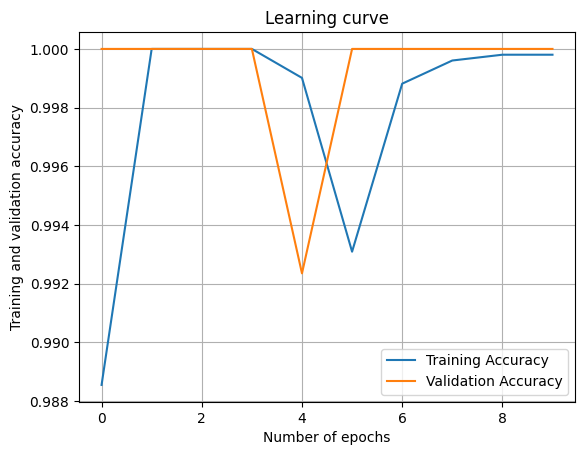

In [151]:
plot_resnet_learning_curve(fine_tuning_accuracy)

# Conclusions

1)

2)

3.  

# Sources

https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

https://scikit-learn.org/stable/modules/clustering.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://keras.io/examples/vision/mnist_convnet/

https://pyimagesearch.com/2021/10/11/pytorch-transfer-learning-and-image-classification/

https://kozodoi.me/blog/20210527/extracting-features